In [ ]:
#Module Import
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd

In [ ]:
#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set the sepecific location for Training Data
data_root='/content/drive/Shareddrives/AI-Drone/Dataset/Vision/train'

In [ ]:
#Set the information of data
IMAGE_SHAPE = (224 , 224) #Image Shape

#Train and Validation Data Information
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20) # Split Train and Validation 80:20
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/Shareddrives/AI-Drone/Dataset/Vision/test
Found 1199 images belonging to 2 classes.
Found 4800 images belonging to 2 classes.


In [ ]:
#Return Batch Shape of Image and Lable
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Drone' 'Nodrone']


In [ ]:
#Model Summary
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Check the Images for UnidentifiedImageError
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/drive/Shareddrives/AI-Drone/Dataset/Vision/test/Drone").rglob("*.jpeg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
#Model Fitting에 필요한 Hpyerparameter 설정 및 Model Fitting
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs = 50,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

In [ ]:
#Save the Weight parameter in Model
saved_model_path = "/content/drive/Shareddrives/AI-Drone/pythonnotebook" #저장된 Path 경로 설정
model.save(saved_model_path)  #Model save
image_model_0525 = tf.keras.models.load_model(saved_model_path)  

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
#Retrun the Prediction results from each class(ex. Drone, No_Drone)
tf_model_predictions = image_model_0525.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
tf_pred_dataframe.head()

Prediction results for the first elements


,Drone,Nodrone
0,0.98677176,0.01322824
1,0.99999940,0.00000054
2,0.99999654,0.00000351
3,1.00000000,0.00000001
4,0.00000231,0.99999774


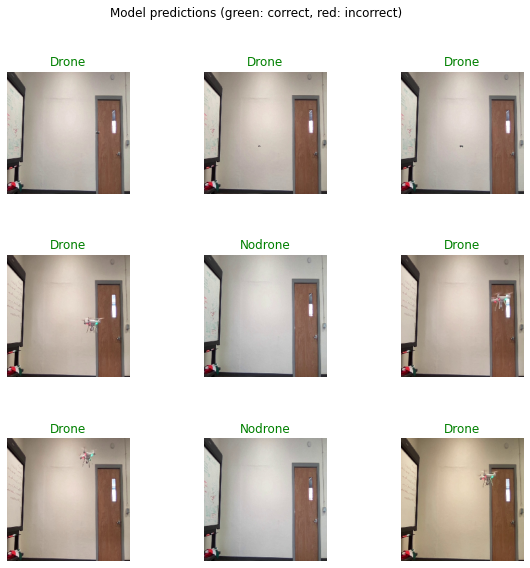

In [ ]:
#Plot the actual result with images and classes
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(val_image_batch[n])
  
  #if data is correct show label with green, if not show lable with red
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red" 
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
hist.keys()


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

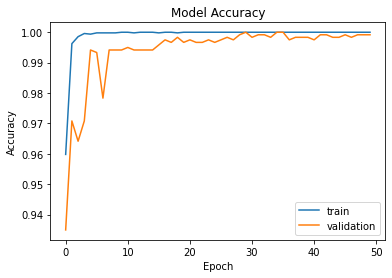

In [ ]:
#Plot the auctual accuracy during the epochs
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'lower right')
plt.show()

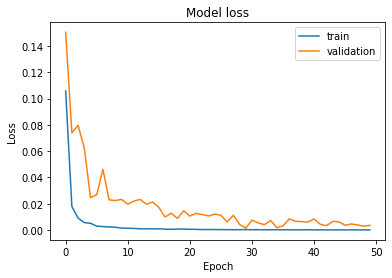

In [ ]:
#Plot the auctual loss during the epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()